In [1]:
import pandas as pd
from datetime import timedelta

In [2]:
df_last = pd.read_csv('data_last.csv')
df_mkt = pd.read_csv('data_mkt_cap.csv')
df_sec = pd.read_csv('data_sector.csv')
df_vol = pd.read_csv('data_volume.csv')
df = pd.merge(pd.merge(df_last, df_vol, how='outer', on=['ticker', 'date']), df_mkt, how='outer', on=['ticker', 'date'])

def genStockList(mv = 1e10):
    return df_sec[df_mkt['mkt_cap'] < mv]['ticker'].values

In [3]:
def genStockTimeSeries(ticker):
    df_stock = df[df['ticker'] == ticker][['date', 'last', 'volume']].copy()
    df_stock.set_index('date' , inplace = True)
    df_stock.index = pd.to_datetime(df_stock.index)
    df_stock[['in', 'out']] = False
    return df_stock

def isInDate(df_stock, date, period = 20, threshold = 0.1, up_rate = 1.03):
    start_loc = df_stock.index.get_loc(date) - period + 1
    df_temp = df_stock.iloc[start_loc: start_loc + period]
    date_highest = df_temp[df_temp['last'] == df_temp['last'].max()].index[0]
    date_lowest = df_temp[df_temp['last'] == df_temp['last'].min()].index[0]
    price_up = df_temp['last'].iloc[-1] >= df_temp['last'].iloc[-2] * up_rate
    volume_up = df_temp['volume'].iloc[-1] >= (df_temp['volume'].iloc[:-1].mean() + df_temp['volume'].iloc[:-1].std())
    if price_up or volume_up:
        crit_of_price = df_temp['last'].iloc[-2] <= df_temp['last'][date_highest] and (df_temp.loc[date_highest:,'last'].diff()).sum() < 0
        max_drawdown = df_temp.loc[[date_lowest, date_highest], 'last'].diff().iloc[1] / df_temp['last'][date_highest]
        if crit_of_price and max_drawdown >= threshold:
            crit_of_volume = df_temp['volume'].iloc[-2] < df_temp['volume'].iloc[period - 1 - int(period / 4) : -2].quantile(.4) or (df_temp['volume'].diff()).sum() < 0
            if crit_of_volume:
                df_stock.loc[date, 'in'] = True
    return

def isOutDate(df_stock, in_date, date, period = 20, threshold1 = 0.95, threshold2 = 0.97, threshold3 = 1.03):
    if date == df_stock.index[-1]:
        df_stock.loc[date, 'out'] = True
    start_loc = df_stock.index.get_loc(in_date) - period + 1
    date_loc = df_stock.index.get_loc(date)
    df_temp = df_stock.iloc[start_loc: date_loc]
    scaled_price = df_temp['last'].iloc[-1] / df_temp['last'].iloc[-2]
    price_change = df_temp['last'].iloc[-1] / df_temp['last'][in_date]
    hist_highest = df_temp['last'].loc[in_date].max()
    date_highest = df_temp[df_temp['last'] == hist_highest].index[-1]
    if scaled_price < threshold1:
        if df_temp.index[-1] - in_date < timedelta(days = period):
            if price_change < threshold2:
                df_stock.loc[date, 'out'] = True
        else:
            if price_change < threshold3:
                df_stock.loc[date, 'out'] = True
            else:
                if df_temp['last'].iloc[-1] < hist_highest:
                    if df_temp['volume'].iloc[-1] > df_temp['volume'].loc[date_highest:].quantile(0.6):
                        df_stock.loc[date, 'out'] = True
    return

def computeInAndOut(df_stock, period = 20, threshold = 0.1, up_rate = 1.05, threshold1 = 0.95, threshold2 = 0.97, threshold3 = 1.03):
    skip = False
    status_in = False
    count = 0
    in_date = None
    for date in df_stock.index[period - 1:]:
        if count == period:
            skip = False
            count = 0
        if status_in and in_date is not None:
            isOutDate(df_stock, in_date, date, period, threshold1, threshold2, threshold3)
            if df_stock['out'][date]:
                skip = False
                status_in = False
        if not skip and not status_in:
            isInDate(df_stock, date, period, threshold, up_rate)
            if df_stock['in'][date]:
                status_in = True
                skip = True
                in_date = date
        if skip and count < period:
            count += 1
    return

def backTest(stockList, period = 20, threshold = 0.1, up_rate = 1.05, threshold1 = 0.95, threshold2 = 0.97, threshold3 = 1.03):
    dictionary = {}
    for ticker in stockList:
        df_stock = genStockTimeSeries(ticker).dropna()
        computeInAndOut(df_stock, period, threshold, up_rate, threshold1, threshold2, threshold3)
        in_dates = df_stock[df_stock['in'] == True].index
        out_dates = df_stock[df_stock['out'] == True].index
        ticker_gain = 0
        for in_date, out_date in zip(in_dates, out_dates):
            ticker_gain += df_stock['last'][out_date] - df_stock['last'][in_date]
        dictionary[ticker] = ticker_gain
    return pd.Series(dictionary)

It is a simple strategy to find market timings. I just used price and volume data to find potential signals for entry and exit. We identify the entry time through the shrank down points, which are statistically computed from last "period" days' data which turns out to be brutal for using same strategy and parameters for all stocks over different market values and industries, etc.

In [4]:
stockList = genStockList(mv = 1e10)
### In fact we should discuss on the market value of listed companies

/var/folders/79/w51_ktqs0fn5qgvwjpqwg4g00000gn/T/ipykernel_52907/2644155871.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return df_sec[df_mkt['mkt_cap'] < mv]['ticker'].values


In [5]:
df_ticker_pl = backTest(stockList, period = 20, threshold = 0.1, up_rate = 1.05, threshold1 = 0.95, threshold2 = 0.97, threshold3 = 1.05)

In [6]:
df_ticker_pl.values.sum()

551724.0

We didn't add more strategies on stop-loss or stop-gain which should be done in the future. And the portfolio allocation is not done neither. They could be done given additional data. The overall absolute gain is not that bad. I didn't compare it to benchmark so I didn't compute sharpe ratio of information ratio. 

<Axes: >

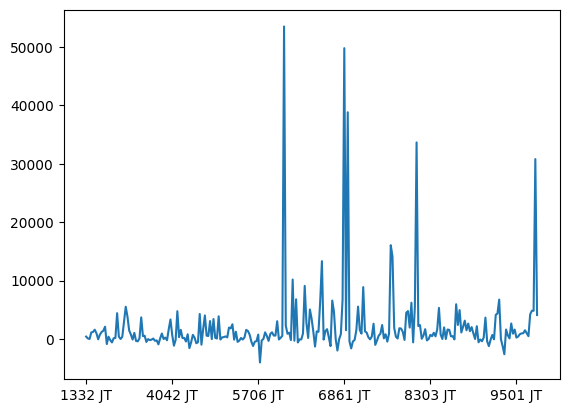

In [7]:
df_ticker_pl.plot()

From this plot one could see that the returns are not that robust overall. One could apply learning techniques to find better parameters for the strategy. More importantly, a discussion on the sections can be very helpful.